This notebook creates the two classification tables from the paper and also allows one to see the numbers from the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# defines how to do the scoring in the cross-validation.
scoring = ['accuracy']

Read in all the data.

In [2]:
feats = pd.read_csv("../../System/feats_train.csv")
feats.set_index('index', inplace=True)
af_labels = feats["class"]
feats.drop('class', axis=1, inplace=True)

bow = pd.read_csv("../../System/bow_train.csv")
bow.set_index('index', inplace=True)
bow.drop('class', axis=1, inplace=True)

bop = pd.read_csv("../../System/bop_train.csv")
bop.set_index('index', inplace=True)
bop.drop('class', axis=1, inplace=True)

fun = pd.read_csv("../../System/function_words_train.csv")
fun.set_index('index', inplace=True)
fun.drop('class', axis=1, inplace=True)

fakes = pd.read_csv("../../System/fake_news_feats_train.csv")
fakes.set_index('index', inplace=True)
fake_labels = fakes["class"]
fakes.drop('class', axis=1, inplace=True)

fake_bow = pd.read_csv("../../System/fake_news_bow_train.csv")
fake_bow.set_index('index', inplace=True)
fake_bow.drop('class', axis=1, inplace=True)

fake_bop = pd.read_csv("../../System/fake_news_bop_train.csv")
fake_bop.set_index('index', inplace=True)
fake_bop.drop('class', axis=1, inplace=True)

fake_fun = pd.read_csv("../../System/fake_news_function_words_train.csv")
fake_fun.set_index('index', inplace=True)
fake_fun.drop('class', axis=1, inplace=True)

Read in the lists of features for each feature set. 

In [3]:
feature_set_names = ['complexity', 'deception', 'details', 'formality', 'humour', 'imagination', 'vagueness']

feature_sets = dict()

# loop through each feature set and read in the features.
for name in feature_set_names:
    curr = []
    with open("../feature_sets/{}.txt".format(name)) as file:
        for line in file:
            if '-' not in line:
                curr.append(line.strip())
    feature_sets[name] = curr

Do all the cross-validation and create table of results.

In [4]:
# dictionary of feature tables and scores.
af_feature_tables = dict()
af_scores = dict()

# Create a feature table for each feature group.
for name in feature_set_names:
    af_feature_tables[name] = feats.loc[:, feature_sets[name]]
    
# add feature table for Hoax Set and Complexity + Details
af_feature_tables['Hoax Set'] = feats
af_feature_tables['Complexity + Detail'] = pd.concat([af_feature_tables['complexity'],
                                                     af_feature_tables['details']], axis=1)
# add feature table for BoPoS and BoPoS + Hoax.
af_feature_tables['Bag-of-PoS'] = bop
af_feature_tables['BoPoS + Hoax'] = pd.concat([feats, bop], axis=1)
    
# run cross validation for each feature set.
for name in af_feature_tables.keys():
    pipeline = Pipeline([
            ('normalizer', StandardScaler()),           # Step1 - normalize data
            ('clf', LogisticRegression())               # Step2 - classifier
            ])
    af_scores[name] = cross_validate(pipeline, af_feature_tables[name],
                                 af_labels, scoring=scoring, cv=10)

In [5]:
# Trains a classifier on AF and then evaluates it on Fake News.
def train_af_test_fake(af_table, fake_table, training_labels, testing_labels):
    classifier = LogisticRegression()
    scaler = StandardScaler()
    scaled_af = scaler.fit_transform(af_table)
    classifier.fit(scaled_af, training_labels)
    scaled_fake = scaler.transform(fake_table)
    predicted = classifier.predict(scaled_fake)
    return metrics.accuracy_score(testing_labels, predicted)

In [6]:
# dictionary of feature tables and scores.
fake_feature_tables = dict()
fake_scores = dict()
fake_trained_on_af = dict()

# Create a feature table for each feature group.
for name in feature_set_names:
    fake_feature_tables[name] = fakes.loc[:, feature_sets[name]]
    
# add feature table for Hoax Set and Complexity + Details
fake_feature_tables['Hoax Set'] = fakes
fake_feature_tables['Complexity + Detail'] = pd.concat([fake_feature_tables['complexity'],
                                                     fake_feature_tables['details']], axis=1)
# add feature table for BoPoS and BoPoS + Hoax.
fake_feature_tables['Bag-of-PoS'] = fake_bop
fake_feature_tables['BoPoS + Hoax'] = pd.concat([fakes, fake_bop], axis=1)
    
# perform classification - both cross-val and train on AF, test on fake for each feature set.
for name in fake_feature_tables.keys():
    pipeline = Pipeline([
            ('normalizer', StandardScaler()),           # Step1 - normalize data
            ('clf', LogisticRegression())               # Step2 - classifier
            ])
    # Perform Cross validation.
    fake_scores[name] = cross_validate(pipeline, fake_feature_tables[name],
                                 fake_labels, scoring=scoring, cv=10)
    # Train on AF, test on fake.
    fake_trained_on_af[name] = train_af_test_fake(af_feature_tables[name],
                                                 fake_feature_tables[name],
                                                 af_labels, fake_labels)

Create a table containing the AF and Fake News cross-validation results.

In [7]:
# Loop through April Fools CV results and put the accuracies in a dataframe.
af_test_scores = dict()
for name in af_feature_tables.keys():
    af_test_scores[name] = af_scores[name]['test_accuracy']
    
af_test_pd = pd.DataFrame(af_test_scores)

# Loop through Fake News CV results and put the accuracies in a dataframe.
fake_test_scores = dict()
for name in fake_feature_tables.keys():
    fake_test_scores[name] = fake_scores[name]['test_accuracy']
    
fake_test_pd = pd.DataFrame(fake_test_scores)

Create the April Fools results chart.

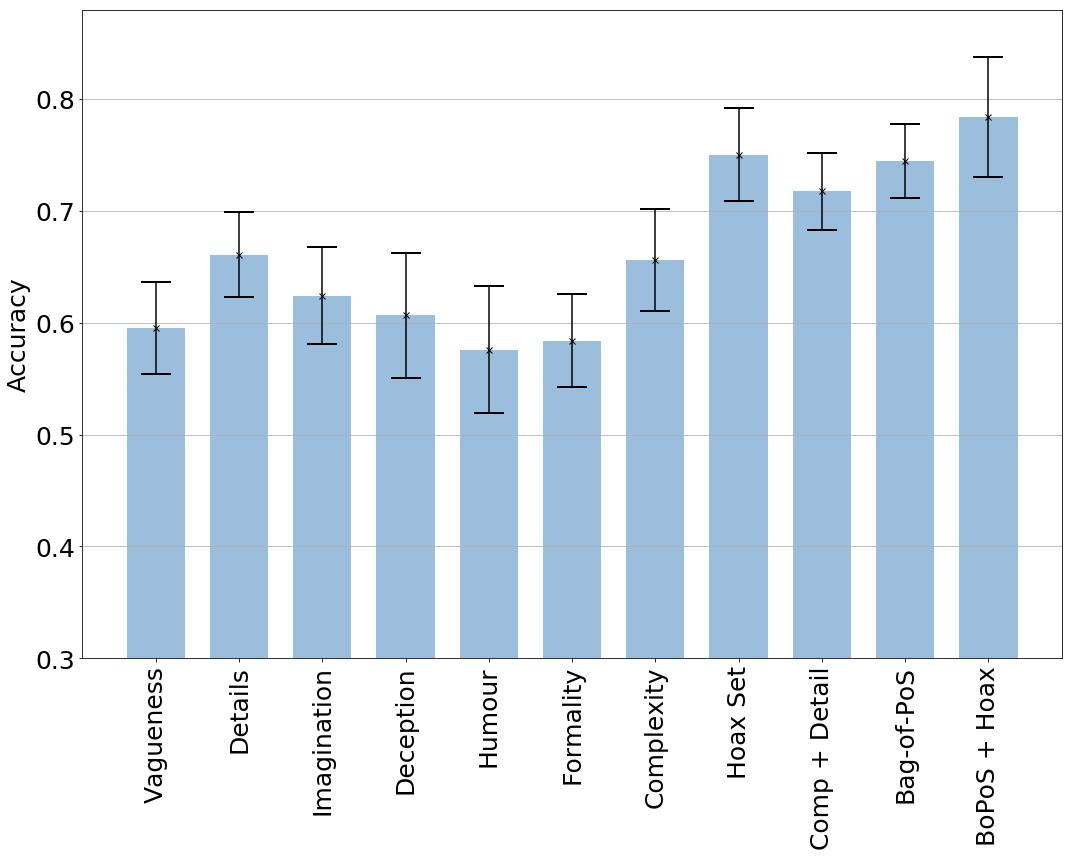

In [8]:
fig, ax = plt.subplots(figsize=(15, 12))
x_pos = np.arange(len(af_test_pd.columns))

# Sort the columns for the graph.
sorted_names = ['vagueness', 'details', 'imagination', 'deception', 'humour', 'formality',
               'complexity', 'Hoax Set', 'Complexity + Detail',
                'Bag-of-PoS', 'BoPoS + Hoax']
sorted_means = [af_test_pd.mean()[name] for name in sorted_names]
sorted_stds = [af_test_pd.std()[name] for name in sorted_names]

# Provide prettier labels for the graph.
axis_labels = ['Vagueness', 'Details', 'Imagination', 'Deception', 'Humour', 'Formality', 
                'Complexity', 'Hoax Set', 'Comp + Detail',
                'Bag-of-PoS', 'BoPoS + Hoax']

col_width = 0.7

# Create the bars.
ax.bar(x=x_pos, height=sorted_means, width=col_width, 
       align='center', alpha=0.5, color="#377eb8")

# Add error bars. These correspond to the standard deviation across the cross-validation folds.
(_, caps, _) = plt.errorbar(x=x_pos, y=sorted_means, yerr=sorted_stds,
                            capsize=15, color='#000000', fmt='x')
# Set error bar colour.
for cap in caps:
    cap.set_color('#000000')
    cap.set_markeredgewidth(2)

# Do some formatting.
ax.set_xticks(x_pos)
ax.set_xticklabels(axis_labels, rotation='vertical')
ax.set_ylim(ymin=0.3)
ax.set_ylabel("Accuracy")
ax.yaxis.grid(True)

ax.tick_params(labelsize=25)
ax.set_ylabel('Accuracy', fontsize=25)

plt.tight_layout()
plt.show()

Create the Fake News results chart.

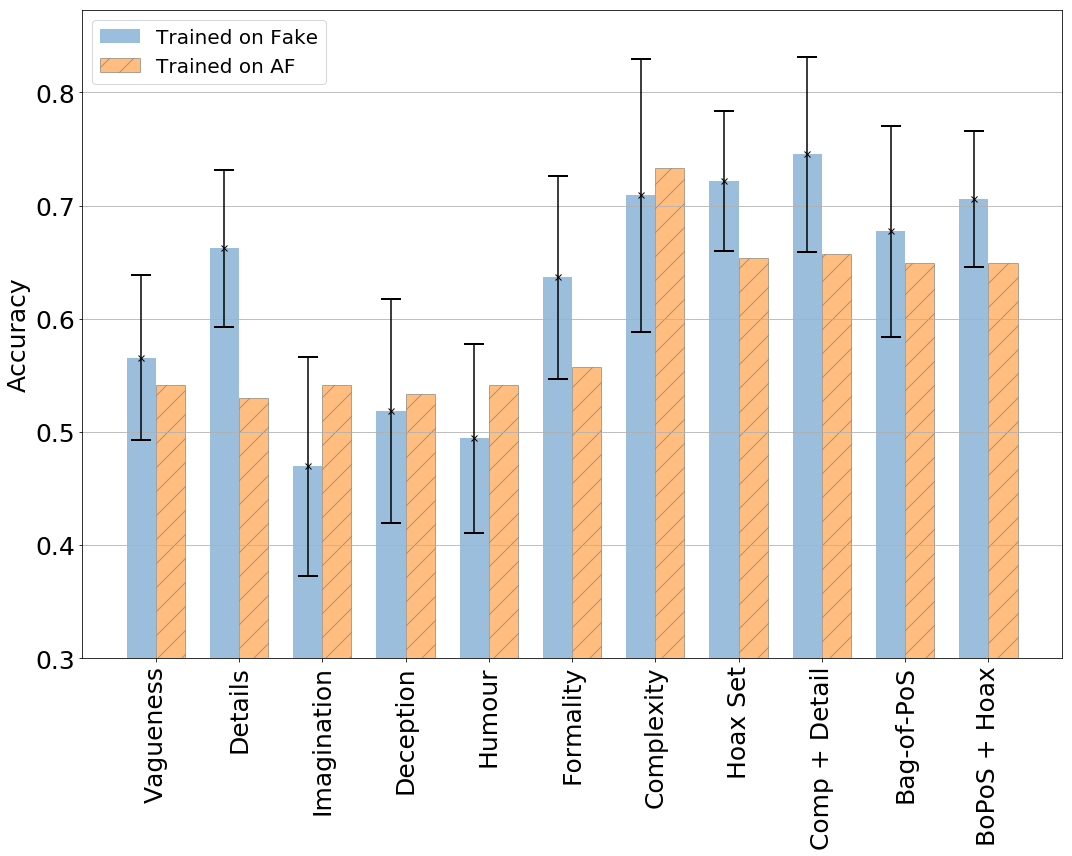

In [9]:
fig, ax = plt.subplots(figsize=(15, 12))
x_pos = np.arange(len(af_test_pd.columns))

# Sort the columns for the graph.
sorted_names = ['vagueness', 'details', 'imagination', 'deception', 'humour', 'formality',
               'complexity', 'Hoax Set', 'Complexity + Detail',
                'Bag-of-PoS','BoPoS + Hoax']
sorted_means = [fake_test_pd.mean()[name] for name in sorted_names]
sorted_stds = [fake_test_pd.std()[name] for name in sorted_names]
sorted_af_fake = [fake_trained_on_af[name] for name in sorted_names]

# Provide prettier labels for the graph.
axis_labels = ['Vagueness', 'Details', 'Imagination', 'Deception', 'Humour', 'Formality', 
                'Complexity', 'Hoax Set', 'Comp + Detail',
                'Bag-of-PoS', 'BoPoS + Hoax']

col_width = 0.35

# Create the Fake News CV bar.
bar1 = ax.bar(x=x_pos, height=sorted_means, width=col_width,
       align='center', alpha=0.5, color="#377eb8")
# Create the Fake News trained on April Fools bar.
bar2 = ax.bar(x=x_pos+col_width, height=sorted_af_fake, width=col_width,
       align='center', alpha=0.5, color="#ff7f00", hatch='/', edgecolor="#636363")

# Add error bars. These correspond to the standard deviation across the cross-validation folds.
(_, caps, _) = plt.errorbar(x=x_pos, y=sorted_means, yerr=sorted_stds,
                            capsize=10, color='#000000', fmt='x')

# Colour the error bars.
for cap in caps:
    cap.set_color('#000000')
    cap.set_markeredgewidth(2)

# Do some formatting.
ax.set_xticks(x_pos+col_width/2)
ax.set_xticklabels(axis_labels, rotation='vertical')
ax.set_ylim(ymin=0.3)
ax.set_ylabel("Accuracy")
ax.yaxis.grid(True)

ax.tick_params(labelsize=25)
ax.set_ylabel('Accuracy', fontsize=25)

ax.legend((bar1, bar2), ("Trained on Fake", "Trained on AF"), prop={'size': 20})

plt.tight_layout()
plt.show()